In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display  import Audio
from sklearn import preprocessing
import seaborn as sns
import missingno as msno

In [52]:
def normalize(x, axis = 0):
    return preprocessing.minmax_scale(x, axis = axis)

def extrae_var(cancion):
    cancion = cancion

    samples, sr = librosa.load(cancion, sr = None, mono = True, offset = 0.0, duration=60)
    
    X = librosa.stft(samples)
    Xdb = librosa.amplitude_to_db(abs(X))

    zero_crossings= librosa.zero_crossings(samples, pad=False)
    zero_c = np.mean(zero_crossings)

    spectral_centroids = librosa.feature.spectral_centroid(y=samples, sr=sr)[0]
    spectral_centroids.shape
    spec_centroid = np.mean(spectral_centroids)

    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    spr = librosa.feature.spectral_rolloff(y=samples + 0.01, sr=sr)[0]
    spec_rollof = np.mean(spr)

    mfccs = librosa.feature.mfcc(y = samples, sr = sr)

    salto = 512
    cromatica = librosa.feature.chroma_stft(y=samples, sr=sr, hop_length=salto)
    croma = np.mean(cromatica)

    hop_length = 512
    env = librosa.onset.onset_strength(y = samples, sr = sr, hop_length = hop_length)
    tempograma = librosa.feature.tempogram(onset_envelope = env, sr = sr, hop_length = hop_length)

    #el onset envelope resalta los momentos 
    #en los que comienzan las notas, golpes u 
    #otros eventos importantes en la música

    auto_c = librosa.autocorrelate(env, max_size = tempograma.shape[0])
    auto_c = librosa.util.normalize(auto_c)
    autocorr = np.mean(auto_c)
    #mostrar los "beats"
    tempo = librosa.feature.rhythm.tempo(onset_envelope = env, sr = sr, hop_length = hop_length)[0]

    FRAME_LENGTH = 1024
    HOP_LENGTH = 512

    rms = librosa.feature.rms(y=samples, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    rms=np.mean(rms)# aquí he metido el rms y de todos los valores he usado la media al igual que el resto, pero sin criterio alguno la verdad

    columnas = ['archivo', 'zero_cr', 'spectral_centroid', 'spectral_rf', 'croma', 'BPM', 'auto_c','rms']
    for x in range(1, 21):
        columnas.append(f'mfcc_{x}')

    df = pd.DataFrame(columns=columnas)

    #Fila de datos
    x = [cancion, zero_c,spec_centroid,spec_rollof, croma, tempo, autocorr,rms]
    x.extend([np.mean(m) for m in mfccs])
    df.loc[len(df)] = x
    return df
    

In [53]:
# Al restructurar las carpetas hay que hacer un script que lea los archivos de cada carpeta

df_t=pd.DataFrame()
for subcarpeta in os.listdir('data'):
    for archivo in os.listdir('data/'+subcarpeta):
        if archivo.endswith('.mp3'):
            cancion='data/'+subcarpeta +'/'+archivo
            df=extrae_var(cancion)
            df_t=pd.concat([df_t,df])
df_t.reset_index(drop=True,inplace=True)

In [54]:
df_t

,archivo,zero_cr,spectral_centroid,spectral_rf,croma,BPM,auto_c,rms,mfcc_1,mfcc_2,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,data/jazz/My Favorite Things.mp3,0.026946,2168.672797,4448.784105,0.412791,127.840909,0.613652,0.077120,-256.755066,152.602188,...,-3.046290,4.901884,-3.958657,3.084962,-8.028246,0.554997,-3.670780,1.222103,-4.024886,4.468877
1,data/jazz/My Funny Valentine.mp3,0.014598,1305.452946,1921.933323,0.433229,125.000000,0.743150,0.052630,-386.650055,151.768677,...,-3.291514,4.984404,0.274270,-2.964208,0.229842,-1.388050,-1.571353,1.577277,-1.369492,-3.672707
2,data/jazz/Round Midnight.mp3,0.025311,1580.077318,2620.684101,0.370905,125.000000,0.539736,0.160215,-229.071762,163.194427,...,-7.825747,-1.249559,-1.325399,-0.014041,0.550254,0.842281,-0.671533,0.158038,-1.834451,-1.130573
3,data/jazz/Strange Fruit.mp3,0.020535,1869.243230,2958.449054,0.401248,119.680851,0.843644,0.057693,-344.670197,148.146133,...,-10.035156,3.331257,-8.649022,-0.768256,-4.784468,3.976687,-3.973443,2.872415,-0.476284,1.433204
4,data/jazz/Summertime.mp3,0.040352,1741.690194,2869.664837,0.284280,127.840909,0.785919,0.027305,-387.219147,164.877533,...,-4.388738,-4.894717,-6.190495,-6.445358,-6.774521,-7.816337,-7.141836,-5.315114,-3.418887,-0.298618
5,data/jazz/Take Five.mp3,0.072371,3978.283535,8804.947176,0.417588,125.000000,0.602755,0.071224,-235.908279,110.371758,...,-1.847541,1.881107,-3.554263,4.005883,0.443784,2.014449,-3.788063,0.346880,-2.179018,3.187922
6,data/jazz/Take the _A_ Train.mp3,0.046763,4030.379570,9579.959396,0.471517,92.213115,0.450913,0.067620,-263.364288,103.131828,...,-5.525870,10.465205,-4.676866,10.763446,-0.844835,2.726712,-3.310702,3.033125,-2.023122,4.800293
7,data/jazz/Yardbird Suite.mp3,0.017205,910.547103,1545.171136,0.408960,106.132075,0.504386,0.143105,-273.367371,195.241730,...,3.964118,-0.349263,-0.020685,0.940674,-3.091676,-3.831722,-0.698162,-2.147858,-2.685197,0.127796
8,data/opera/Caro nome.mp3,0.034098,1623.182797,1581.435523,0.227862,127.840909,0.776265,0.035295,-434.797272,139.314117,...,-8.718883,-5.198875,-4.083566,-6.115485,-3.270789,-0.104594,-2.495745,-3.151165,-0.281937,4.673926
9,data/opera/Che gelida manina.mp3,0.046056,1824.299188,2806.796847,0.280441,122.282609,0.810726,0.113033,-270.192352,150.295975,...,-13.217053,-0.827520,-6.701449,-0.561700,1.711245,-6.231705,-5.366082,-5.790746,-1.181367,0.574685


In [55]:
# se elimina la variable archivo para el cluster y escalado de datos OJO LOS RESULTADOS VARIAN MUCHO SI SE ESCALAN LOS DATOS O NO
# HABRÄ QUE ESTUDIARLO BIEN.
train=df_t.drop('archivo', axis=1).copy()
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_scaled=scaler.fit_transform(train)
train_scaled=pd.DataFrame(train_scaled, columns=train.columns.to_list())

In [56]:
train_scaled.std()

zero_cr              1.012739
spectral_centroid    1.012739
spectral_rf          1.012739
croma                1.012739
BPM                  1.012739
auto_c               1.012739
rms                  1.012739
mfcc_1               1.012739
mfcc_2               1.012739
mfcc_3               1.012739
mfcc_4               1.012739
mfcc_5               1.012739
mfcc_6               1.012739
mfcc_7               1.012739
mfcc_8               1.012739
mfcc_9               1.012739
mfcc_10              1.012739
mfcc_11              1.012739
mfcc_12              1.012739
mfcc_13              1.012739
mfcc_14              1.012739
mfcc_15              1.012739
mfcc_16              1.012739
mfcc_17              1.012739
mfcc_18              1.012739
mfcc_19              1.012739
mfcc_20              1.012739
dtype: float64

In [57]:
# pca para representación solo, habría que analizar la varianza que explica si queremos usarla realmente 
# y comprobar con el AIC y BIC del modelo final para tomar una decisión.
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
x=pca.fit_transform(train_scaled)
df_pca=pd.DataFrame(x,columns=['a','b'])

In [58]:
# función para el metodo del codo y ver numero de clusters recomendados.

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
def elbow_method(data, max_clusters=5):
    sum_of_squared_distances = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)
    # Graficar la curva del codo
    plt.plot(range(1, max_clusters+1), sum_of_squared_distances, 'bx-')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Suma de las Distancias al Cuadrado')
    plt.title('Curva del Codo')
    plt.show()

c:\Users\nicol\anaconda3\envs\MCD_23_24\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


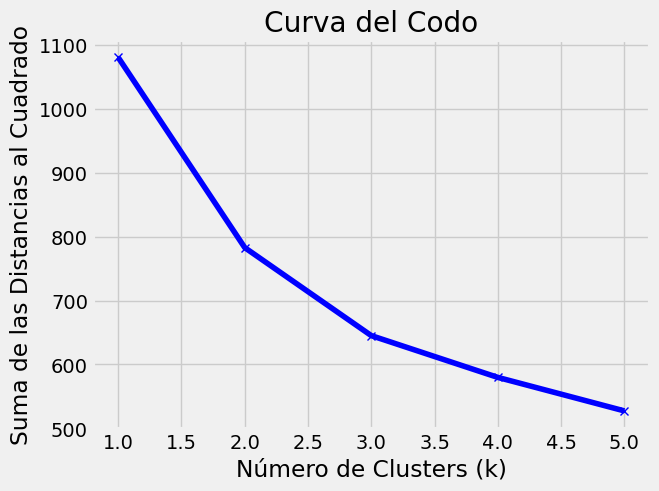

In [59]:
elbow_method(train_scaled)


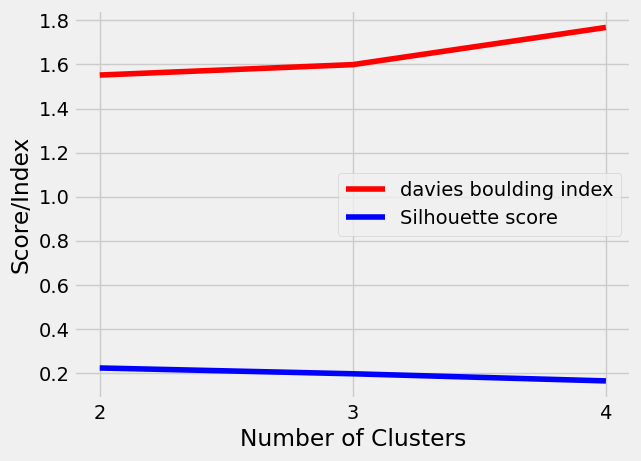

In [60]:
#script para representar coeficiente de silueta y de davies para ver numero de clusters
from sklearn.metrics import davies_bouldin_score, silhouette_score
 

silhouette_coefficients = []
davies_bouldin_scores = []
# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_scaled)
    sil_score = silhouette_score(train_scaled, kmeans.labels_)
    silhouette_coefficients.append(sil_score)
    db_score = davies_bouldin_score(train_scaled, kmeans.labels_)
    davies_bouldin_scores.append(db_score)
 

plt.style.use("fivethirtyeight")
plt.plot(range(2, 5), davies_bouldin_scores, color='red', label = 'davies boulding index')
plt.plot(range(2, 5), silhouette_coefficients, color='blue', label = 'Silhouette score')
plt.xticks(range(2, 5))

plt.xlabel("Number of Clusters")
plt.ylabel("Score/Index")
plt.legend()
plt.show()

In [61]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(train_scaled)

df_t['Target']=kmeans.labels_
df_pca['Target']=kmeans.labels_

<BarContainer object of 27 artists>

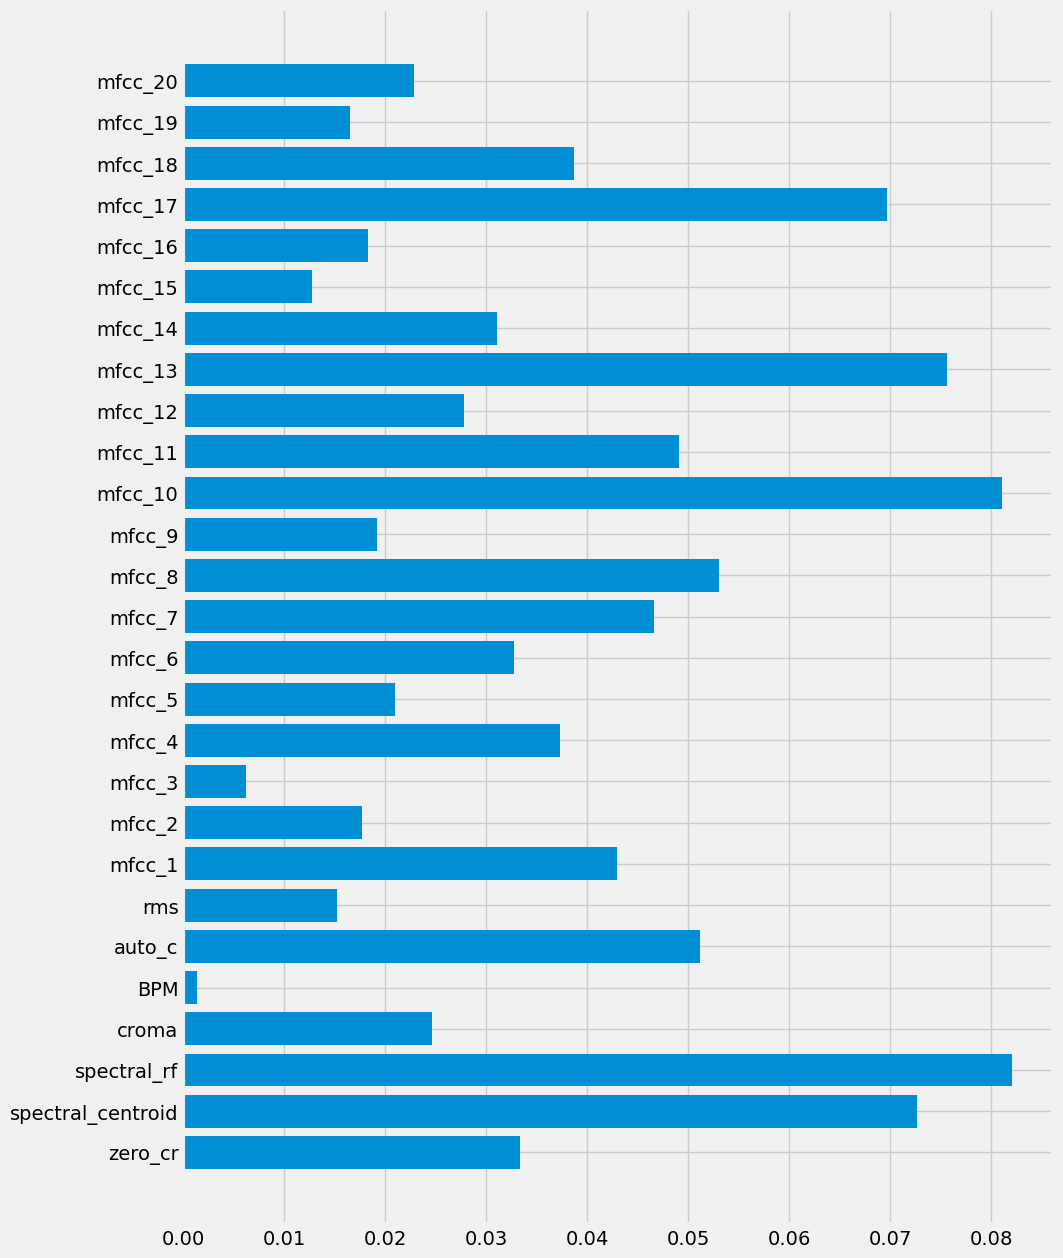

In [62]:
#importancia de las variables si usasemos un Clasificador de Arbol de decisión.
from sklearn.ensemble import RandomForestClassifier
reg=RandomForestClassifier()
reg.fit(X = train_scaled, y = kmeans.labels_)
plt.figure(figsize = (10,15))
plt.barh(reg.feature_names_in_,reg.feature_importances_)

<AxesSubplot:xlabel='a', ylabel='b'>

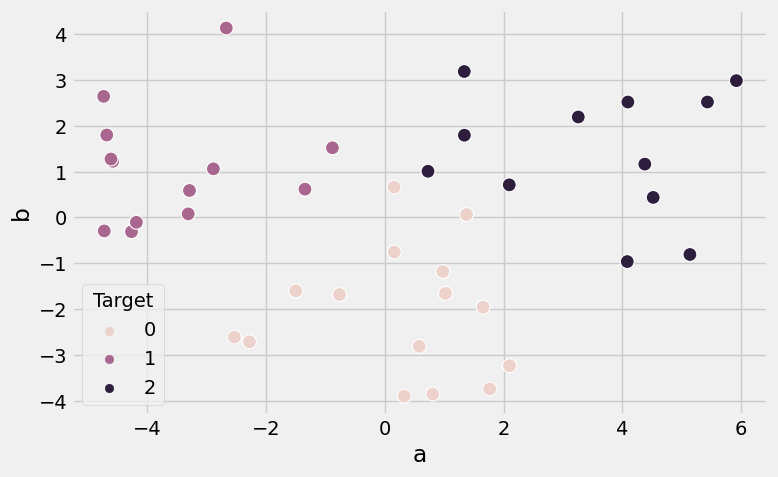

In [63]:
#representación perra final
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_pca, x='a', y='b', hue='Target', s =100)
